# General examples of los calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sympy.printing.pretty.pretty_symbology import line_width

# Setup time new roman font for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Computational burden

The computational burden is the average slope of the simulation time vs execution time.

In general, the simulation time is equally spaced according to some step size $\delta t$.

The execution time, instead, might vary across different runs due to underlying hardware, software, etc.

In [ ]:
# Simulation time
sim_time = np.linspace(0, 60, 100)

# Execution time realizations
n_real = 50
exec_time = np.zeros((n_real, len(sim_time)))
for i in range(n_real):
    for j in range(1, len(sim_time)):
        increment = np.random.uniform(0.5, 2.0)
        exec_time[i, j] = exec_time[i, j-1] + increment

In [ ]:
from greyboxmodels.voi.metrics.computational_load import computational_load

# Computational load
slopes = [computational_load(sim_time, exec_time[i, :]) for i in range(n_real)]
comp_load = np.mean(slopes)

eff_curve = comp_load * sim_time

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(n_real):
    ax.plot(sim_time, exec_time[i, :], linewidth=0.2, color='gray')

ax.plot(sim_time, eff_curve, linewidth=1, color='black', label=f'$L_1$ = {comp_load:.2f}')

ax.set_xlabel('Simulation time')
ax.set_ylabel('Execution time')
ax.set_xlim([0, 60])
ax.set_ylim([0, 135])
ax.set_title('Computational burden')

# Modify the ticks. First, x-axis
x_pos = [0, 10, 20, 30, 50, 60]
x_label = ["$t(0)$", "$t(1)$", "$t(2)$", "$...$", "$t(\eta_l-1)$", "$t(\eta_l)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label)

# Second, y-axis
y_pos = [0, 25, 50, 75, 110, 135]
y_label = ["$t^{exec}(0)$", "$t^{exec}(1)$", "$t^{exec}(2)$", "$...$", "$t^{exec}(\eta_l-1)$", "$t^{exec}(\eta_l)$"]
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
None

## Fidelity

The fidelity is the time-averaged Kolmogorov-Smirnov distance between the ground truth and the model predictions.

For each time step, we have a pdf for the ground truth and a pdf for the model predictions.

Then, we calculate the Kolmogorov-Smirnov distance between the two distributions for each time step.

Finally, we average the distances across all time steps.

In [2]:
sim_time = np.linspace(0, 10, 100)

In [3]:
def dummy_model(t, p0, p1, p2, n_samples=500):
    X = np.zeros((n_samples, len(t)))
    # X[:, 0] = p0 * np.ones(n_samples)
    X[:, 1] = p0 * np.ones(n_samples)
    for i in range(2, len(t)):
        X[:, i] = X[:, i-1] + p1 * X[:, i-2] + np.random.normal(0, p2, n_samples)

    return X


In [4]:
np.random.seed(42)
n_samples = 1000

# ground truth distributions
p0_gt = np.random.uniform(0.8, 1.2)
p1_gt = np.random.uniform(-1.0, -0.8)
p2_gt = np.random.uniform(0.001, 0.003)
ground_truth = dummy_model(sim_time, p0_gt, p1_gt, p2_gt, n_samples=n_samples)

print(p0_gt, p1_gt, p2_gt)

# Two models
p0_model1 = 1.0
p1_model1 = -0.9
p2_model1 = 0.002
model_predictions1 = dummy_model(sim_time, p0_model1, p1_model1, p2_model1, n_samples=n_samples)

p0_model2 = 0.95
p1_model2 = -0.85
p2_model2 = 0.0026
model_predictions2 = dummy_model(sim_time, p0_model2, p1_model2, p2_model2, n_samples=n_samples)

0.949816047538945 -0.8098571387180168 0.0024639878836228103


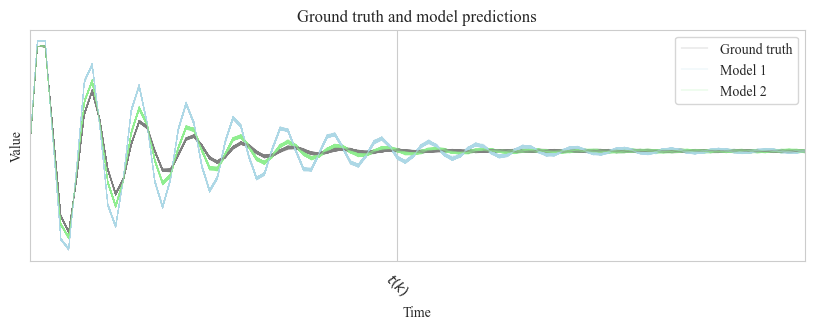

In [26]:
# Plot realizations of the ground truth and model predictions with different colors
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

for i in range(n_samples):
    ax.plot(sim_time, ground_truth[i, :], linewidth=0.2, color='gray', label='Ground truth')
    ax.plot(sim_time, model_predictions1[i, :], linewidth=0.2, color='lightblue', label='Model 1')
    ax.plot(sim_time, model_predictions2[i, :], linewidth=0.2, color='lightgreen', label='Model 2')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Ground truth and model predictions')
ax.set_xlim([0, sim_time[-1]])

# Add the legend for the different lines, only first three
ax.legend(['Ground truth', 'Model 1', 'Model 2'])

# Modify the ticks. First, x-axis
x_pos = [sim_time[47]]
x_label = ["$t(k)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, rotation=-45)

# Second, y-axis
y_pos = []
y_label = []
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
None

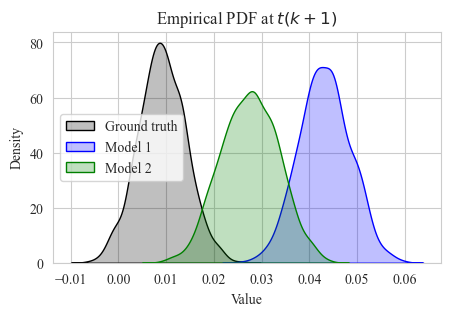

In [30]:
# Select some time and plot the distributions
k = 46

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.kdeplot(ground_truth[:, k], color='black', linewidth=1, label='Ground truth', fill=True)
sns.kdeplot(model_predictions1[:, k], color='blue', linewidth=1, label='Model 1', fill=True)
sns.kdeplot(model_predictions2[:, k], color='green', linewidth=1, label='Model 2', fill=True)

ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title(f'Empirical PDF at $t(k+1)$')
ax.legend()

None

In [33]:
# Calculate the lack of fit for fidelity at each time step
import greyboxmodels.voi.metrics.lack_of_fit as lof
from importlib import reload
reload(lof)

ks1_list = []
ks2_list = []

for i in range(len(sim_time)):
    lof1, info1 = lof.ks_statistic(model_predictions1[:, i], ground_truth[:, i])
    lof2, info2 = lof.ks_statistic(model_predictions2[:, i], ground_truth[:, i])
    ks1_list.append(info1)
    ks2_list.append(info2)


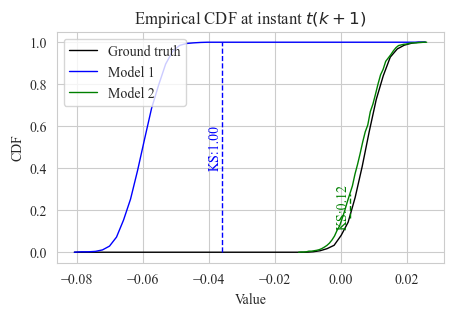

In [55]:
k = 47

# Get the CDF and KS data from the infor dictionaries
cdf_gt = ks1_list[k]['ecdf_ref']
cdf_m1 = ks1_list[k]['ecdf']
cdf_m2 = ks2_list[k]['ecdf']

# Add one more bin to the end
bins1_diff = ks1_list[k]['bins'][1] - ks1_list[k]['bins'][0]
bins1 = np.append(ks1_list[k]['bins'], ks1_list[k]['bins'][-1] + bins1_diff)

bins2_diff = ks2_list[k]['bins'][1] - ks2_list[k]['bins'][0]
bins2 = np.append(ks2_list[k]['bins'], ks2_list[k]['bins'][-1] + bins2_diff)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(bins1, cdf_gt, color='black', linewidth=1, label='Ground truth')
ax.plot(bins1, cdf_m1, color='blue', linewidth=1, label='Model 1')
ax.plot(bins2, cdf_m2, color='green', linewidth=1, label='Model 2')

# Plot the KS statistic
ks1_loc = ks1_list[k]['ks_location']
ks1_val = ks1_list[k]['ecdf_at_ks'] + ks1_list[k]['ks_value']
ks1_off = ks1_list[k]['ecdf_at_ks']

ks2_loc = ks2_list[k]['ks_location']
ks2_val = ks2_list[k]['ecdf_at_ks'] + ks2_list[k]['ks_value']
ks2_off = ks2_list[k]['ecdf_at_ks']

ax.plot([ks1_loc, ks1_loc], [ks1_off, ks1_val], color='blue', linestyle='--', linewidth=1)
ax.plot([ks2_loc, ks2_loc], [ks2_off, ks2_val], color='green', linestyle='--', linewidth=1)

# Add text with the KS values next to the lines, at the vertical center of them and aligned to the right, rotated 90 degrees
ax.text(ks1_loc, (ks1_off + ks1_val) / 2, f'KS:{ks1_list[k]["ks_value"]:.2f}', color='blue', ha='right', va='center', rotation=90)
ax.text(ks2_loc, (ks2_off + ks2_val) / 2, f'KS:{ks2_list[k]["ks_value"]:.2f}', color='green', ha='right', va='center', rotation=90)

ax.set_xlabel('Value')
ax.set_ylabel('CDF')
ax.set_title(f'Empirical CDF at instant $t(k+1)$')
ax.legend(loc='upper left')

None

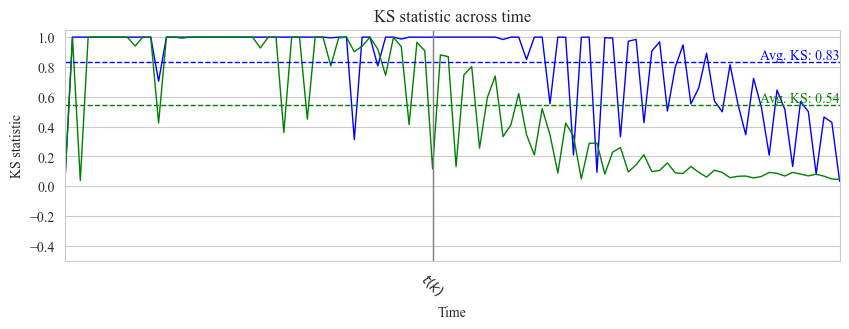

In [62]:
# Plot the KS statistic across time
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ks1_values = [ks1_list[i]['ks_value'] for i in range(len(sim_time))]
ks2_values = [ks2_list[i]['ks_value'] for i in range(len(sim_time))]
ax.plot(sim_time, ks1_values, color='blue', linewidth=1, label='Model 1')
ax.plot(sim_time, ks2_values, color='green', linewidth=1, label='Model 2')

# Average
avg_ks1 = np.mean(ks1_values)
avg_ks2 = np.mean(ks2_values)

ax.plot(sim_time, avg_ks1 * np.ones(len(sim_time)), color='blue', linestyle='--', linewidth=1, label=f'Avg. Model 1: {avg_ks1:.2f}')
ax.plot(sim_time, avg_ks2 * np.ones(len(sim_time)), color='green', linestyle='--', linewidth=1, label=f'Avg. Model 2: {avg_ks2:.2f}')

# Text with the average values, place on top of the lines
ax.text(sim_time[-1], avg_ks1, f'Avg. KS: {avg_ks1:.2f}', color='blue', ha='right', va='bottom')
ax.text(sim_time[-1], avg_ks2, f'Avg. KS: {avg_ks2:.2f}', color='green', ha='right', va='bottom')

# Highlight instant k with vertical line
ax.axvline(sim_time[k], color='gray', linewidth=1)

ax.set_xlabel('Time')
ax.set_ylabel('KS statistic')
ax.set_title('KS statistic across time')
ax.set_xlim([0, sim_time[-1]])
ax.set_ylim([-0.5, 1.05])
# ax.legend()

# Xticks
x_pos = [sim_time[k]]
x_label = ["$t(k)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, rotation=-45)

# Yticks
# y_pos = [0, 0.1, 0.2, 0.3, 0.4]
# y_label = ["0", "0.1", "0.2", "0.3", "0.4"]
# ax.set_yticks(y_pos)
# ax.set_yticklabels(y_label)
None